In [18]:
import os, torch
#from torchdiffeq import odeint_adjoint as odeint
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
import time
import sys
sys.path.append('../')
from typing import Tuple, Any

%load_ext autoreload
%autoreload 2


import interflow as itf
import interflow.prior as prior
import interflow.fabrics
import interflow.fabrics_extra
import interflow.stochastic_interpolant as stochastic_interpolant
import interflow.realnvp as realnvp
from torch import autograd
from functorch import jacfwd, vmap


if torch.cuda.is_available():
    print('CUDA available, setting default tensor residence to GPU.')
    itf.util.set_torch_device('cuda')
else:
    print('No CUDA device found!')
print(itf.util.get_torch_device())


print("Torch version:", torch.__version__)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
CUDA available, setting default tensor residence to GPU.
cuda
Torch version: 2.5.1


In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[Device] Using: {device} | CUDA_VISIBLE_DEVICES={os.environ.get('CUDA_VISIBLE_DEVICES')}")
if device.type == "cuda":
    try:
        print("[Device] GPU:", torch.cuda.get_device_name(0))
        torch.backends.cudnn.benchmark = True
    except Exception as _e:
        print("[Device] GPU name unavailable:", _e)

def move_to(obj, device=device, non_blocking=True):
    """Recursively move tensors in nested containers to device."""
    import torch
    if torch.is_tensor(obj):
        return obj.to(device=device, non_blocking=non_blocking)
    if isinstance(obj, dict):
        return {k: move_to(v, device, non_blocking) for k, v in obj.items()}
    if isinstance(obj, (list, tuple)):
        seq = [move_to(x, device, non_blocking) for x in obj]
        return type(obj)(seq) if isinstance(obj, tuple) else seq
    return obj

print("[Device] Helper move_to() is defined.")


[Device] Using: cuda | CUDA_VISIBLE_DEVICES=None
[Device] GPU: NVIDIA L40S
[Device] Helper move_to() is defined.


## Utility Functions

In [20]:
def grab(var):
    """Take a tensor off the gpu and convert it to a numpy array on the CPU."""
    return var.detach().cpu().numpy()


def compute_likelihoods(
    b: torch.nn.Module,
    s: torch.nn.Module,
    interpolant: stochastic_interpolant.Interpolant,
    n_save: int,
    n_step: int,
    eps: int,
    bs: int
) -> Tuple[torch.tensor, torch.tensor]:
    """Draw samples from the probability flow and SDE models, and compute likelihoods."""
    
    
    #sde_flow = stochastic_interpolant.SDEIntegrator(
    #    b=b, s=s, eps=eps, interpolant=interpolant, n_save=n_save, n_likelihood=1, n_step=n_step
    #)
    pflow = stochastic_interpolant.PFlowIntegrator(b=b,  
                                                  method='dopri5', 
                                                  interpolant=interpolant,
                                                  n_step=3)
    
    #with torch.no_grad():
    x0_tests  = base(bs)
        #xfs_sde   = sde_flow.rollout_forward(x0_tests) # [n_save x bs x dim]
        #xf_sde    = grab(xfs_sde[-1].squeeze())        # [bs x dim]
        # ([1, bs, dim], [bs])
        #x0s_sdeflow, _ = sde_flow.rollout_likelihood(xfs_sde[-1])
    

    logp0                  = base.log_prob(x0_tests)            # [bs]
    xfs_pflow, dlogp_pflow = pflow.rollout(x0_tests)            # [n_save x bs x dim], [n_save x bs]
    logpx_pflow            = logp0 + dlogp_pflow[-1].squeeze()  # [bs]
    xf_pflow               = grab(xfs_pflow[-1].squeeze())      # [bs x dim]


    return xf_pflow, logpx_pflow #, xf_sde


def log_metrics(
    b: torch.nn.Module,
    s: torch.nn.Module,
    interpolant: stochastic_interpolant.Interpolant,
    n_save: int,
    n_step: int,
    likelihood_bs: int, 
    b_loss: torch.tensor,
    s_loss: torch.tensor,
    loss: torch.tensor,
    b_grad: torch.tensor,
    s_grad: torch.tensor,
    eps: torch.tensor,
    data_dict: dict
) -> None:
    # log loss and gradient data
    b_loss   = grab(b_loss).mean(); data_dict['b_losses'].append(b_loss)
    s_loss   = grab(s_loss).mean(); data_dict['s_losses'].append(s_loss)
    loss     = grab(loss).mean(); data_dict['losses'].append(loss)
    b_grad   = grab(b_grad).mean(); data_dict['b_grads'].append(b_grad)
    s_grad   = grab(s_grad).mean(); data_dict['s_grads'].append(s_grad)

    
    # compute and log likelihood data
    _, _, logpx_pflow = compute_likelihoods(
        b, s, interpolant, n_save, n_step, eps, likelihood_bs)
    
    logpx_pflow = grab(logpx_pflow).mean(); data_dict['logps_pflow'].append(logpx_pflow)
    

def make_plots(
    b: torch.nn.Module,
    s: torch.nn.Module,
    interpolant: stochastic_interpolant.Interpolant,
    n_save: int,
    n_step: int, ## number of sde steps in [0,1]
    likelihood_bs: int,
    counter: int,
    metrics_freq: int,
    eps: torch.tensor,
    data_dict: dict,
    save_path: str = None,  # Add save_path parameter
    epoch: int = None,       # Add epoch parameter for file naming
    width: float = 1.0,
    height: float = 0.1,
) -> None:
    """Make plots to visualize samples and evolution of the likelihood."""
    # compute likelihood and samples for SDE and probability flow.
    xf_pflow, logpx_pflow = compute_likelihoods(
        b, s, interpolant, n_save, n_step, eps, likelihood_bs
    )

    ### Create figure with 3 subplots: samples, losses, and v_sq_norm
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Plot 1: Samples from PFlow
    axes[0].hist2d(xf_pflow[:,0], xf_pflow[:,1], bins=100, range=[[-width,width],[-height,height]])
    axes[0].set_title("Samples from PFlow", fontsize=14)
    axes[0].set_xlabel("x")
    axes[0].set_ylabel("y")

    # Plot 2: Losses over epochs (linear scale since losses can be negative)
    if 'v_losses' in data_dict and len(data_dict['v_losses']) > 0:
        epochs = np.arange(1, len(data_dict['v_losses']) + 1)
        axes[1].plot(epochs, data_dict['v_losses'], label='v_loss', color='blue', linewidth=2)
        if 'flow_losses' in data_dict and len(data_dict['flow_losses']) > 0:
            axes[1].plot(epochs, data_dict['flow_losses'], label='flow_loss', color='red', linewidth=2)
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Loss')
        axes[1].set_title('Training Losses', fontsize=14)
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        # Add a horizontal line at y=0 for reference
        axes[1].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
        # No log scale since losses can be negative

    # Plot 3: v_squared_norm over epochs
    if 'v_squared_norm' in data_dict and len(data_dict['v_squared_norm']) > 0:
        epochs = np.arange(1, len(data_dict['v_squared_norm']) + 1)
        axes[2].plot(epochs, data_dict['v_squared_norm'], color='green', linewidth=2)
        axes[2].set_xlabel('Epoch')
        axes[2].set_ylabel(r'$\mathbb{E}[|v_t|^2]$')
        axes[2].set_title('Velocity Field Squared Norm', fontsize=14)
        axes[2].grid(True, alpha=0.3)

    # Add overall title
    if epoch is not None:
        fig.suptitle(f"Epoch {epoch} | ε = {grab(eps)}", fontsize=16, y=1.02)
    else:
        fig.suptitle(f"ε = {grab(eps)}", fontsize=16, y=1.02)

    plt.tight_layout()

    # Save the figure if save_path is provided
    if save_path is not None:
        if epoch is not None:
            filename = f"{save_path}/plots_epoch_{epoch:04d}.png"
        else:
            filename = f"{save_path}/plots.png"
        plt.savefig(filename, dpi=100, bbox_inches='tight')
        print(f"Saved plot to {filename}")

    plt.show()
    

def estimate_v_squared_norm(
      v: torch.nn.Module,
      interpolant,
      base,
      target,
      n_samples: int = 1000,
      batch_size: int = 100,
      device = None
  ) -> float:
    """
    Monte Carlo estimate of E_{t,x_0,x_1}[|v_t(I_t(x_0,x_1))|^2].

    Draws mini-batches of (x_0, x_1, t) with t ~ U[0,1] and averages |v_t|^2.
    Handles arbitrary sample counts without bias toward boundary times.
    """
    if n_samples <= 0:
        return 0.0

    batch_size = max(1, batch_size)

    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    v_was_training = v.training
    flow_model = getattr(interpolant, 'flow_model', None)
    flow_was_training = flow_model.training if flow_model is not None else None

    v.eval()
    if flow_model is not None:
        flow_model.eval()

    total_sq = 0.0
    total_count = 0
    remaining = n_samples

    with torch.no_grad():
        while remaining > 0:
            current_bs = min(batch_size, remaining)
            t = torch.rand(1, device=device)
            x0s = base(current_bs).to(device)
            x1s = target(current_bs).to(device)

            xts = interpolant.calc_xt(t, x0s, x1s)
            if isinstance(xts, tuple):
                xts = xts[0]

            vts = v(xts, t)
            batch_sq = vts.pow(2).sum(dim=-1)

            total_sq += batch_sq.sum().item()
            total_count += batch_sq.numel()
            remaining -= current_bs

    if v_was_training:
        v.train()
    else:
        v.eval()

    if flow_model is not None:
        if flow_was_training:
            flow_model.train()
        else:
            flow_model.eval()

    return float(total_sq / total_count) if total_count else 0.0

def estimate_v_squared_norm_grid(
      v: torch.nn.Module,
      interpolant,
      base,
      target,
      n_samples: int = 1000,
      n_time_points: int = 10,  # Grid resolution
      device=None
  ) -> float:
      """
      Use fixed time grid, sample uniformly from (x0, x1) at each time.
      More stable and efficient in practice.
      """
      if device is None:
          device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

      v.eval()
      flow_model = getattr(interpolant, 'flow_model', None)
      if flow_model is not None:
          flow_model.eval()

      # Fixed time grid
      time_grid = torch.linspace(0, 1, n_time_points, device=device)
      samples_per_time = n_samples // n_time_points

      total_sq = 0.0
      total_count = 0

      with torch.no_grad():
          for t_val in time_grid:
              t = t_val.unsqueeze(0)  # [1]

              # Sample at this time point
              x0s = base(samples_per_time).to(device)
              x1s = target(samples_per_time).to(device)

              xts = interpolant.calc_xt(t, x0s, x1s)
              if isinstance(xts, tuple):
                  xts = xts[0]

              vts = v(xts, t)
              batch_sq = vts.pow(2).sum(dim=-1)

              total_sq += batch_sq.sum().item()
              total_count += batch_sq.numel()

      # Restore training mode
      if v.training:
          v.train()
      if flow_model is not None and flow_model.training:
          flow_model.train()

      return float(total_sq / total_count) if total_count else 0.0

def estimate_partial_t_v_squared_norm(
      v: torch.nn.Module,
      interpolant,
      base,
      target,
      n_samples: int = 1000,
      batch_size: int = 100,
      device = None
  ) -> float:
    """
    Monte Carlo estimate of E_{t,x_0,x_1}[|∂_t v_t(I_t(x_0,x_1), t)|^2].

    Uses jacobian-vector products to obtain ∂_t v_t efficiently for each batch.
    """
    if n_samples <= 0:
        return 0.0

    batch_size = max(1, batch_size)

    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    v_was_training = v.training
    flow_model = getattr(interpolant, 'flow_model', None)
    flow_was_training = flow_model.training if flow_model is not None else None

    v.eval()
    if flow_model is not None:
        flow_model.eval()

    total_sq = 0.0
    total_count = 0
    remaining = n_samples

    while remaining > 0:
        current_bs = min(batch_size, remaining)

        x0s = base(current_bs).to(device)
        x1s = target(current_bs).to(device)
        t = torch.rand(1, device=device)
        t.requires_grad_(True)

        def v_at_time(t_input: torch.Tensor) -> torch.Tensor:
            if t_input.dim() == 0:
                t_input = t_input.unsqueeze(0)
            xts_local = interpolant.calc_xt(t_input, x0s, x1s)
            if isinstance(xts_local, tuple):
                xts_local = xts_local[0]
            return v(xts_local, t_input)

        _, dv_dt = torch.autograd.functional.jvp(
            v_at_time,
            t,
            torch.ones_like(t),
            create_graph=False,
            strict=False,
        )

        if dv_dt.dim() == 1:
            dv_dt = dv_dt.unsqueeze(0)

        batch_sq = dv_dt.pow(2).sum(dim=-1).detach()

        total_sq += batch_sq.sum().item()
        total_count += batch_sq.numel()
        remaining -= current_bs

    if v_was_training:
        v.train()
    else:
        v.eval()

    if flow_model is not None:
        if flow_was_training:
            flow_model.train()
        else:
            flow_model.eval()

    return float(total_sq / total_count) if total_count else 0.0




In [21]:
def total_grad_norm(params):
    norms = []
    for p in params:
        if p.grad is not None:
            norms.append(p.grad.detach().pow(2).sum())
    if not norms:
        return 0.0
    return (torch.stack(norms).sum().sqrt()).item()

def set_requires_grad(module, flag: bool):
    for p in module.parameters():
        p.requires_grad_(flag)
        
def train_step(
    bs: int,
    interpolant: stochastic_interpolant.Interpolant,
    v: torch.nn.Module,
    opt_v: torch.optim.Optimizer,
    opt_flow: torch.optim.Optimizer,  # Changed from opt_T to opt_flow for clarity
    sched_v: torch.optim.lr_scheduler._LRScheduler, 
    sched_flow: torch.optim.lr_scheduler._LRScheduler,  # Changed from sched_T to sched_flow for clarity
    n_inner: int = 1,  # Number of inner minimization steps
    n_outer: int = 1,  # Number of outer maximization steps
    reuse_batch: bool = True,
    clip_v: float = 1.0,
    clip_flow: float = 1.0,
    device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    train_v_only: bool = False,
    warmup_step: int = 0,
    base_fn=None,
    target_fn=None,
    base_kwargs=None,
    target_kwargs=None,
):
    """
    Take a single step of adversarial training.
    Inner loop: minimize loss w.r.t. v
    Outer loop: maximize loss w.r.t. interpolant.flow_model

    Pass custom data generators via base_fn/target_fn. If None, falls back to
    globals: base and target (or target_rhombus if target is absent).

    - base_fn: callable like base(bs, **base_kwargs)
    - target_fn: callable like target(bs, **target_kwargs)
    - base_kwargs/target_kwargs: optional dicts forwarded to the callables
    """
    # Default to globally defined functions if not provided
    if base_fn is None:
        base_fn = globals().get('base')
    if target_fn is None:
        target_fn = globals().get('target', globals().get('target_rhombus'))
    base_kwargs = {} if base_kwargs is None else base_kwargs
    target_kwargs = {} if target_kwargs is None else target_kwargs

    if hasattr(interpolant, 'set_step'):
        interpolant.set_step(warmup_step)
        
    v.train()
    interpolant.flow_model.train()
    if reuse_batch:
        # construct batch
        x0s = base_fn(bs, **base_kwargs)
        x1s = target_fn(bs, **target_kwargs)
        ts  = torch.rand(size=(bs,1))
    
    # Inner minimization: minimize over v
    set_requires_grad(interpolant.flow_model, False)
    set_requires_grad(v, True)
    
    v_grad_val = 0.0
    for _ in range(n_inner):
        if not reuse_batch:
            x0s = base_fn(bs, **base_kwargs).to(device)
            x1s = target_fn(bs, **target_kwargs).to(device)
            ts  = torch.rand(bs, device=device)
            
        opt_v.zero_grad(set_to_none = True)
        loss_v = loss_fn_v(v, x0s, x1s, ts, interpolant)
        loss_v.backward()
        
        if clip_v is not None and clip_v < float('inf'):
            torch.nn.utils.clip_grad_norm_(v.parameters(), clip_v)
        v_grad_val = total_grad_norm(v.parameters())
        
        opt_v.step()
        sched_v.step()
    
    if not train_v_only:
        # Outer maximization: maximize over interpolant.flow_model
        set_requires_grad(v, False)
        set_requires_grad(interpolant.flow_model, True)

        flow_grad_val = 0.0
        for _ in range(n_outer):
            if not reuse_batch:
                x0s = base_fn(bs, **base_kwargs).to(device)
                x1s = target_fn(bs, **target_kwargs).to(device)
                ts  = torch.rand(bs, device=device)

            opt_flow.zero_grad(set_to_none = True)
            loss_flow = loss_fn_v(v, x0s, x1s, ts, interpolant)

            (-loss_flow).backward()  # Negative for maximization

            if clip_flow is not None and clip_flow < float('inf'):
                torch.nn.utils.clip_grad_norm_(interpolant.flow_model.parameters(), clip_flow)
            flow_grad_val = total_grad_norm(interpolant.flow_model.parameters())        

            opt_flow.step()
            sched_flow.step()
        # re-enable grads for next call
        set_requires_grad(v, True)
        set_requires_grad(interpolant.flow_model, True)

        # Return the final loss values and gradients for logging
        return loss_v.detach(), loss_flow.detach(), torch.tensor(v_grad_val), torch.tensor(flow_grad_val)
    else:
        # re-enable grads for next call
        set_requires_grad(v, True)
        set_requires_grad(interpolant.flow_model, True)
        # Return the final loss values and gradients for logging
        return loss_v.detach(), torch.tensor(v_grad_val)
    
    

## Target

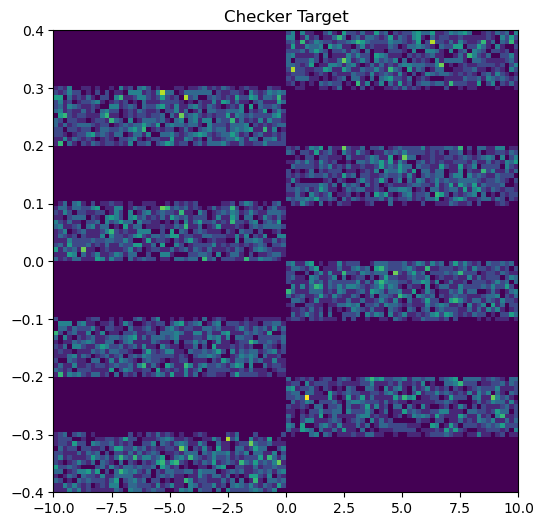

Batch Shape: (10000, 2)


In [22]:
ndim = 2
def target(bs):
    x1 = torch.rand(bs, dtype=torch.float32) * 4 - 2
    x2_ = torch.rand(bs, dtype=torch.float32) - torch.randint(2, (bs,), dtype=torch.float32) * 2
    x2 = x2_ + (torch.floor(x1) % 2)
    return (torch.cat([x1[:, None], x2[:, None]], 1) * 2)

def target_rect(bs,
                w=10.0, h=0.1,          # rectangle (tile) width & height
                layers_x=2, layers_y=4, # how many tiles across (x) and down (y) in the checker
                scale=1.0,              # final global scaling (like your *2)
                device=None, dtype=None):
    """
    Rectangular checkerboard with adjustable aspect ratio and number of layers.

    - Tiles are width w and height h.
    - layers_x, layers_y control how many tiles we place horizontally/vertically.
    - Classic checker staggering: every odd column is shifted by +h.
    - Output is centered around (0,0) and then scaled by `scale`.
    """
    if device is None:
        device = torch.device('cpu')
    if dtype is None:
        dtype = torch.get_default_dtype()

    # choose a column and a vertical "base strip"
    col = torch.randint(layers_x, (bs,), device=device)
    base_row = torch.randint(layers_y, (bs,), device=device)

    # x within the chosen column tile
    x_in = torch.rand(bs, dtype=dtype, device=device) * w
    x = (col.to(dtype) + x_in / w) * w  # in [0, layers_x*w)

    # y within a checker tile, staggered by column parity
    y_in = torch.rand(bs, dtype=dtype, device=device) * h
    # rows span height 2*h per pair because of staggering (checker alternation)
    y = (base_row.to(dtype) * 2.0 * h) + ((col % 2).to(dtype) * h) + y_in  # in [0, 2*layers_y*h)

    # center to ~zero and scale
    x = x - (layers_x * w) / 2.0
    y = y - (layers_y * h)
    out = torch.stack([x, y], dim=1) * scale
    return out


def target_rhombus(bs,
                   s=1.0,                 # side length of the rhombus (both edges equal)
                   angle_deg=10.0,        # interior angle between edges a and b (0<angle<180, != 0/180)
                   layers_x=4,            # how many tiles along the 'a' direction
                   layers_y=4,            # how many (checker) pairs along the 'b' direction
                   scale=2.0,
                   device=None, dtype=None):
    """
    True rhombus checkerboard sampler.

    Construction:
      - Lattice edges: a and b with |a|=|b|=s and angle `angle_deg` between them.
      - Checker staggering: along b, every odd a-column is shifted by +b/2 (i%2).
      - Indices: u in [0, layers_x), v in [0, 2*layers_y) with parity offset.
      - We sample uniformly inside a single rhombus cell by adding u_in, v_in ∈ [0,1).

    Output:
      Tensor of shape [bs, 2].
    """
    if device is None:
        device = torch.device('cpu')
    if dtype is None:
        dtype = torch.get_default_dtype()

    # Integer tile indices for the checker tiling
    i = torch.randint(layers_x, (bs,), device=device)           # column along a
    j = torch.randint(layers_y, (bs,), device=device)           # row-pair along b

    # Uniform offsets inside a rhombus cell
    u_in = torch.rand(bs, device=device, dtype=dtype)           # along a
    v_in = torch.rand(bs, device=device, dtype=dtype)           # along b

    # Staggering to make a checker: v steps by 2, with +1 for odd columns
    u = i.to(dtype) + u_in                                      # [0, layers_x)
    v = (2 * j + (i % 2)).to(dtype) + v_in                      # [0, 2*layers_y)

    # Build rhombus lattice basis (equal side lengths, non-orthogonal)
    theta = math.radians(angle_deg)
    a = torch.tensor([s, 0.0], device=device, dtype=dtype)                      # |a|=s
    b = torch.tensor([s * math.cos(theta), s * math.sin(theta)],                # |b|=s
                     device=device, dtype=dtype)

    # Center the cloud approximately at the origin
    u_c = layers_x / 2.0
    v_c = layers_y       # because v spans 2*layers_y "b-steps"
    pts = (u - u_c).unsqueeze(1) * a + (v - v_c).unsqueeze(1) * b

    return pts * scale

def target_parallelogram(bs,
                         len_a=1,           # length of first side
                         len_b=5.0,           # length of second side
                         angle_deg=60.0,      # interior angle between edges a and b (0<angle<180, != 0/180)
                         layers_x=2,          # how many tiles along the 'a' direction
                         layers_y=3,          # how many (checker) pairs along the 'b' direction
                         scale=1.0,
                         device=None, dtype=None):
    """
    Parallelogram checkerboard sampler with independent control of two side lengths.

    Construction:
      - Lattice edges: a and b with |a|=len_a, |b|=len_b and angle `angle_deg` between them.
      - Checker staggering: along b, every odd a-column is shifted by +b/2 (i%2).
      - Indices: u in [0, layers_x), v in [0, 2*layers_y) with parity offset.
      - We sample uniformly inside a single parallelogram cell by adding u_in, v_in ∈ [0,1).

    Parameters:
      - len_a: length of the first (horizontal-ish) side
      - len_b: length of the second side
      - angle_deg: angle between the two sides (0 < angle < 180)
      - layers_x, layers_y: number of tiles in each direction
      - scale: global scaling factor applied at the end

    Output:
      Tensor of shape [bs, 2].
    """
    if device is None:
        device = torch.device('cpu')
    if dtype is None:
        dtype = torch.get_default_dtype()

    # Integer tile indices for the checker tiling
    i = torch.randint(layers_x, (bs,), device=device)           # column along a
    j = torch.randint(layers_y, (bs,), device=device)           # row-pair along b

    # Uniform offsets inside a parallelogram cell
    u_in = torch.rand(bs, device=device, dtype=dtype)           # along a
    v_in = torch.rand(bs, device=device, dtype=dtype)           # along b

    # Staggering to make a checker: v steps by 2, with +1 for odd columns
    u = i.to(dtype) + u_in                                      # [0, layers_x)
    v = (2 * j + (i % 2)).to(dtype) + v_in                      # [0, 2*layers_y)

    # Build parallelogram lattice basis (different side lengths, non-orthogonal)
    theta = math.radians(angle_deg)
    a = torch.tensor([len_a, 0.0], device=device, dtype=dtype)                          # |a|=len_a
    b = torch.tensor([len_b * math.cos(theta), len_b * math.sin(theta)],                # |b|=len_b
                     device=device, dtype=dtype)

    # Center the cloud approximately at the origin
    u_c = layers_x / 2.0
    v_c = layers_y       # because v spans 2*layers_y "b-steps"
    pts = (u - u_c).unsqueeze(1) * a + (v - v_c).unsqueeze(1) * b

    return pts * scale



target_samples = grab(target_rect(10000))


fig = plt.figure(figsize=(6,6))
plt.hist2d(target_samples[:,0], target_samples[:,1], bins = 100, range=[[-10,10],[-0.4,0.4]]);
plt.title("Checker Target")
plt.show()


print("Batch Shape:", target_samples.shape)
# target_logp_est = target.log_prob(target(10000)).mean()

## Base

In [23]:
# Configurable base distribution
base_variance = 3.0 # Adjust this value as needed (e.g., 0.5, 1.0, 2.0, etc.)

base_loc = torch.zeros(ndim, device=device, dtype=torch.float32)
base_var = torch.ones(ndim, device=device, dtype=torch.float32) * base_variance
base = prior.SimpleNormal(base_loc, base_var)

print(f"Base distribution: N(0, {base_variance})")
base_samples = grab(base(20000))

Base distribution: N(0, 3.0)


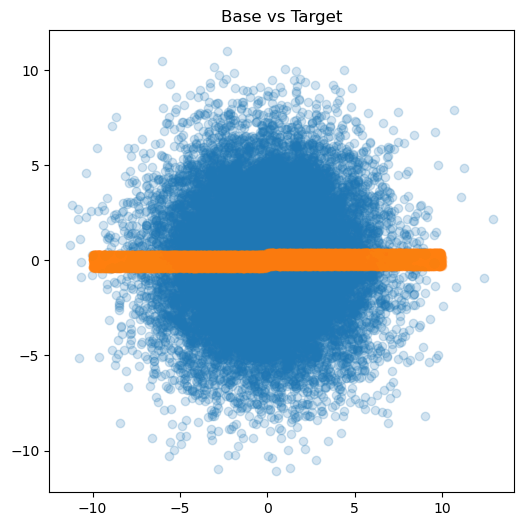

In [24]:
fig = plt.figure(figsize=(6,6,))
plt.scatter(base_samples[:,0], base_samples[:,1],  label = 'base', alpha = 0.2);
plt.scatter(target_samples[:,0], target_samples[:,1], alpha = 0.2);
plt.title("Bimodal Target")
plt.title("Base vs Target")
plt.show()

## Define Interpolants

In [25]:
path = "nonlinear"
flow_config = {
    "num_layers": 2,
    "time_embed_dim": 2,
    "hidden": 32,
    "mlp_blocks": 2,
    "activation": "gelu",
    "use_layernorm":  False,
    "use_permutation": True,
    # smoothness
    "fourier_min_freq": 1.0,
    "fourier_max_freq": 5.0,
    "vector_use_spectral_norm": False,
    "vector_log_scale_clamp":  5.0,
    "vector_use_soft_clamp":  True,
    }

data_type = "vector"
data_dim = 2

interpolant = stochastic_interpolant.Interpolant(path=path, gamma_type = None,\
    flow_config=flow_config, data_type=data_type, data_dim=data_dim)

# check trainable parameters
# These should be the same object
print(f"self.It is bound to flow_model: {interpolant.It.__self__ is interpolant.flow_model}")

# Check trainable parameters
trainable_params = sum(p.numel() for p in interpolant.flow_model.parameters())
print(f"Flow model has {trainable_params:,} trainable parameters")

self.It is bound to flow_model: True
Flow model has 2,500 trainable parameters


In [26]:
path = 'one-sided-trig'

# Create interpolant without diagonal scaling for rectangular target
interpolant_aux = stochastic_interpolant.Interpolant(
    path=path, 
    gamma_type=None,
)

In [27]:
class WarmupInterpolant(torch.nn.Module):
    """
    Configurable interpolant selector that can choose between base and auxiliary interpolants.

    Parameters:
    -----------
    interpolant_base : torch.nn.Module
        The primary (complex) interpolant, typically nonlinear flow
    interpolant_aux : torch.nn.Module
        The auxiliary (simple) interpolant, typically linear or one-sided-trig
    mode : str
        Selection mode: 'base', 'aux', or 'warmup'
        - 'base': Always use interpolant_base
        - 'aux': Always use interpolant_aux
        - 'warmup': Transition from aux to base over warmup_steps
    warmup_steps : int
        Number of steps for warmup transition (only used if mode='warmup')
    """
    def __init__(self, interpolant_base, interpolant_aux, mode='aux', warmup_steps=1000):
        super().__init__()
        self.interpolant_base = interpolant_base
        self.interpolant_aux = interpolant_aux
        self.mode = mode
        self.warmup_steps = warmup_steps
        self.current_step = 0

        # Validate mode
        if mode not in ['base', 'aux', 'warmup']:
            raise ValueError(f"Invalid mode: {mode}. Must be 'base', 'aux', or 'warmup'")

    def __getattr__(self, name):
        """Forward all unknown attributes to the active interpolant."""
        # Avoid infinite recursion for module attributes
        if name in ['interpolant_base','interpolant_aux', 'mode', 'warmup_steps', 'current_step']:
            return super().__getattr__(name)

        # For calc_xt and dtIt, use our custom versions
        if name in ['calc_xt', 'dtIt']:
            return super().__getattr__(name)

        # Forward to the appropriate interpolant based on mode
        if self.mode == 'base':
            return getattr(self.interpolant_base, name)
        elif self.mode == 'aux':
            return getattr(self.interpolant_aux, name)
        else:  # warmup mode
            # For attributes like flow_model, always forward to base
            return getattr(self.interpolant_base, name)

    def set_step(self, step):
        self.current_step = step

    def set_mode(self, mode):
        """Change the interpolant selection mode."""
        if mode not in ['base', 'aux', 'warmup']:
            raise ValueError(f"Invalid mode: {mode}. Must be 'base', 'aux', or 'warmup'")
        self.mode = mode

    def get_warmup_factor(self):
        """Get blending factor for warmup mode."""
        if self.mode == 'base':
            return 1.0
        elif self.mode == 'aux':
            return 0.0
        else:  # warmup mode
            if self.current_step >= self.warmup_steps:
                return 1.0
            return 0.5 * (1 - np.cos(np.pi * self.current_step / self.warmup_steps))

    def calc_xt(self, t, x0, x1):
        """Calculate interpolated point based on current mode."""
        if self.mode == 'base':
            return self.interpolant_base.calc_xt(t, x0, x1)
        elif self.mode == 'aux':
            return self.interpolant_aux.calc_xt(t, x0, x1)
        else:  # warmup mode
            xt_complex = self.interpolant_base.calc_xt(t, x0, x1)
            xt_simple = self.interpolant_aux.calc_xt(t, x0, x1)
            alpha = self.get_warmup_factor()
            return alpha * xt_complex + (1 - alpha) * xt_simple

    def dtIt(self, t, x0, x1):
        """Calculate time derivative based on current mode."""
        if self.mode == 'base':
            return self.interpolant_base.dtIt(t, x0, x1)
        elif self.mode == 'aux':
            return self.interpolant_aux.dtIt(t, x0, x1)
        else:  # warmup mode
            dtIt_complex = self.interpolant_base.dtIt(t, x0, x1)
            dtIt_simple = self.interpolant_aux.dtIt(t, x0, x1)
            alpha = self.get_warmup_factor()
            return alpha * dtIt_complex + (1 - alpha) * dtIt_simple

    def get_active_interpolant_name(self):
        """Get descriptive name of the currently active interpolant configuration."""
        if self.mode == 'base':
            return "nonlinear"
        elif self.mode == 'aux':
            return "linear"
        else:  # warmup
            factor = self.get_warmup_factor()
            if factor == 0.0:
                return "linear"
            elif factor == 1.0:
                return "nonlinear"
            else:
                return f"warmup_{factor:.2f}"

In [28]:
def compute_time_smoothness_loss(
      interpolant, 
      base, 
      target, 
      n_samples=100,
      n_time_points=10,
      eps=0.01,
      device=None
  ):
    """
    Compute smoothness regularization for the interpolant.
    Penalizes large second derivatives in time.
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    total_smoothness = 0.0

    # Sample across time grid
    ts = torch.linspace(0.1, 0.9, n_time_points, device=device)  # Avoid boundaries

    for t in ts:
        # Sample data
        x0s = base(n_samples).to(device)
        x1s = target(n_samples).to(device)

        # Compute at three time points for second derivative
        t_minus = torch.clamp(t - eps, 0, 1).unsqueeze(0)
        t_center = t.unsqueeze(0)
        t_plus = torch.clamp(t + eps, 0, 1).unsqueeze(0)

        # Get interpolations
        xt_minus = interpolant.calc_xt(t_minus, x0s, x1s)
        xt_center = interpolant.calc_xt(t_center, x0s, x1s)
        xt_plus = interpolant.calc_xt(t_plus, x0s, x1s)

        if isinstance(xt_minus, tuple):
            xt_minus, xt_center, xt_plus = xt_minus[0], xt_center[0], xt_plus[0]

        # Approximate second derivative
        d2_xt_dt2 = (xt_plus - 2*xt_center + xt_minus) / (eps**2)

        # Penalize large second derivatives
        smoothness = torch.mean(d2_xt_dt2.pow(2))
        total_smoothness += smoothness

    return total_smoothness / n_time_points

def compute_jacobian_regularization(
      interpolant,
      x0s,
      x1s,
      t,
      eps=0.01
  ):
    """
    Regularize the Jacobian of the flow to be smooth.
    """
    x0s = x0s.requires_grad_(True)
    x1s = x1s.requires_grad_(True)

    # Get interpolation
    xt = interpolant.calc_xt(t, x0s, x1s)
    if isinstance(xt, tuple):
        xt = xt[0]

    # Compute Jacobian norm
    jacobian = torch.autograd.grad(
      xt.sum(),
      [x0s, x1s],
      create_graph=True,
      retain_graph=True
    )

    jac_norm = sum(j.pow(2).mean() for j in jacobian)
    return jac_norm

def train_step_with_regularization(
      bs: int,
      interpolant,
      v: torch.nn.Module,
      opt_v: torch.optim.Optimizer,
      opt_flow: torch.optim.Optimizer,
      sched_v, 
      sched_flow,
      n_inner: int = 100,
      n_outer: int = 1,
      lambda_smooth: float = 0.1,  # Smoothness weight
      lambda_jac: float = 0.01,     # Jacobian weight
      warmup_step: int = 0,
      device=None,
  ):
    """
    Adversarial training with smoothness regularization.
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Update warmup if using WarmupInterpolant
    if hasattr(interpolant, 'set_step'):
        interpolant.set_step(warmup_step)

    # Sample batch
    x0s = base(bs).to(device)
    x1s = target(bs).to(device)
    ts = torch.rand(bs, device=device).reshape(bs,1)

    # Inner minimization: train v
    set_requires_grad(interpolant.flow_model, False)
    set_requires_grad(v, True)

    for _ in range(n_inner):
        opt_v.zero_grad()
        loss_v = loss_fn_v(v, x0s, x1s, ts, interpolant)
        loss_v.backward()
        #torch.nn.utils.clip_grad_norm_(v.parameters(), 1.0)
        opt_v.step()

    # Outer maximization: train interpolant with regularization
    set_requires_grad(v, False)
    set_requires_grad(interpolant.flow_model, True)

    for _ in range(n_outer):
        opt_flow.zero_grad()

        # Main adversarial loss
        loss_flow = loss_fn_v(v, x0s, x1s, ts, interpolant)

#         # Smoothness regularization
#         smooth_loss = compute_time_smoothness_loss(
#           interpolant, base, target,
#           n_samples=50, device=device
#         )

#         # Jacobian regularization
#         jac_loss = compute_jacobian_regularization(
#           interpolant, x0s, x1s, ts[0]
#         )

        # Combined loss (maximize main, minimize regularization)
        total_loss = -loss_flow #+ lambda_smooth * smooth_loss + lambda_jac * jac_loss

        total_loss.backward()
        #torch.nn.utils.clip_grad_norm_(interpolant.flow_model.parameters(), 0.5)  # Small!
        opt_flow.step()

    sched_v.step()
    sched_flow.step()

    set_requires_grad(v, True)
    set_requires_grad(interpolant.flow_model, True)

    return loss_v.detach(), loss_flow.detach()#, smooth_loss.detach(), jac_loss.detach()

## smooth initialization
def initialize_smooth_interpolant(flow_config):
    """
    Initialize interpolant to be very smooth initially.
    """
    smooth_config = flow_config.copy()
    smooth_config.update({
      "num_layers": 2,  # Start with very few layers
      "hidden": 64,      # Small network
      "mlp_blocks": 2,
      "vector_log_scale_clamp": 0.5,  # Very small initially
      "vector_use_soft_clamp": True,
      "vector_use_spectral_norm": True,
      "fourier_max_freq": 10.0,  # Very low frequencies initially
    })

    # Create interpolant
    interpolant = stochastic_interpolant.Interpolant(
      path="nonlinear",
      gamma_type=None,
      flow_config=smooth_config,
      data_type="vector",
      data_dim=2
    )

    # Initialize flow near identity
    with torch.no_grad():
        for param in interpolant.flow_model.parameters():
            param.data *= 0.1  # Scale down all parameters

    return interpolant

In [29]:
# ============================================================================
# INTERPOLANT CONFIGURATION
# ============================================================================

# Choose which interpolant to use
INTERPOLANT_MODE = 'base'  # Options: 'base', 'aux', 'warmup'
# 'base' = nonlinear flow (complex)
# 'aux' = one-sided-trig (simple)
# 'warmup' = transition from aux to base over N_warmup steps

N_warmup = 50
N_main = 10
N_finetune = 10

# Create the configurable interpolant
warmup_interpolant = WarmupInterpolant(
    interpolant_base=interpolant,      # nonlinear flow
    interpolant_aux=interpolant_aux,   # one-sided-trig
    mode=INTERPOLANT_MODE,
    warmup_steps=N_warmup
)

print(f"Created WarmupInterpolant with mode: {INTERPOLANT_MODE}")
print(f"Base interpolant: nonlinear flow")
print(f"Auxiliary interpolant: one-sided-trig")
print(f"Active interpolant: {warmup_interpolant.get_active_interpolant_name()}")

Created WarmupInterpolant with mode: base
Base interpolant: nonlinear flow
Auxiliary interpolant: one-sided-trig
Active interpolant: nonlinear


#### Initialize optimizer, scheduler, etc.

In [30]:
base_lr_v      = 2e-3
base_lr_flow   = 2e-4  # learning rate for flow model (T_t)
hidden_sizes = [256, 256, 256, 256]
in_size      = (ndim+1)
out_size     = (ndim)
inner_act    = 'relu'
final_act    = 'none'
print_model  = True

# Deep ResNet (For complex time-dependent dynamics)
v = itf.fabrics_extra.make_resnet(
    hidden_sizes=[256, 256, 256, 256],  # Can be deeper due to skip connections
    in_size=in_size,
    out_size=out_size,
    inner_act='gelu',
    use_layernorm=True,
    dropout=0.0  # No dropout for 2D usually
)




eps          = torch.tensor(0)
N_epoch      = 500
bs           = 1000    # Increased batch size for better GPU utilization
n_inner      = 1000     # inner minimization steps for v
n_outer      = 100     # outer maximization steps for flow model

#v         = itf.fabrics.make_fc_net(hidden_sizes=hidden_sizes, in_size=in_size, out_size=out_size, inner_act=inner_act, final_act=final_act)
opt_v     = torch.optim.AdamW(v.parameters(), lr=base_lr_v, betas=(0.5,0.9), weight_decay=1e-4)
# opt_flow  = torch.optim.AdamW(warmup_interpolant.flow_model.parameters(), lr=base_lr_flow, betas=(0.5,0.9), weight_decay=1e-4)
sched_v   = torch.optim.lr_scheduler.StepLR(optimizer=opt_v, step_size=20*n_inner, gamma=0.8)
# sched_flow = torch.optim.lr_scheduler.StepLR(optimizer=opt_flow, step_size=20*n_outer, gamma=0.8)

# opt_v = torch.optim.AdamW(v.parameters(), lr=base_lr_v, betas=(0.5,0.9), weight_decay=1e-4)
opt_flow = torch.optim.AdamW(warmup_interpolant.flow_model.parameters(),lr=base_lr_flow, betas=(0.5,0.9), weight_decay=1e-4)

# Use cosine annealing with warm restarts
# sched_v = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
#       optimizer=opt_v,
#       T_0=20*n_inner,      # Restart every 30 epochs
#       T_mult=1,            # Keep period constant
#       eta_min=1e-5
#     )

sched_flow = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
      optimizer=opt_flow,
      T_0=20*n_outer,      # Restart every 30 epochs
      T_mult=1,            # Keep period constant  
      eta_min=1e-5         # Never go below this
    )

plot_bs      = 50000  # number of samples to use when plotting
metrics_freq = 50    # how often to log metrics, e.g. if logp is not super cheap don't do it everytime
plot_freq    = 500   # how often to plot
n_save       = 10    # how often to checkpoint SDE integrator
loss_fac     = 4.0   # ratio of learning rates for w to v
n_step       = 100   # number of steps taken by the SDE in [0,1]

target_kwargs = {'w': 10.0, 'h': 0.1, 'layers_x':2, 'layers_y':4, 'scale':1.0}

if print_model:
    print("Here's the model v:", v)

Here's the model v: InputWrapper(
  (v): Sequential(
    (0): Linear(in_features=3, out_features=256, bias=True)
    (1): GELU(approximate='none')
    (2): ResBlock(
      (fc1): Linear(in_features=256, out_features=256, bias=True)
      (fc2): Linear(in_features=256, out_features=256, bias=True)
      (activation): GELU(approximate='none')
      (layernorm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (dropout): Identity()
    )
    (3): ResBlock(
      (fc1): Linear(in_features=256, out_features=256, bias=True)
      (fc2): Linear(in_features=256, out_features=256, bias=True)
      (activation): GELU(approximate='none')
      (layernorm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (dropout): Identity()
    )
    (4): ResBlock(
      (fc1): Linear(in_features=256, out_features=256, bias=True)
      (fc2): Linear(in_features=256, out_features=256, bias=True)
      (activation): GELU(approximate='none')
      (layernorm): LayerNorm((256,), eps=1e-05, ele

In [31]:
data_dict = {
    'v_losses': [],
    'flow_losses': [],  # Changed from T_losses
    'v_grads': [],
    'flow_grads': [],   # Changed from T_grads
    'times': [],
    'logps_pflow': [],
    'v_squared_norm': [],  # Add E[|v|^2] tracking
    'partial_t_v_squared_norm': [],  # Add E[|∂_t v_t|^2] tracking
}

counter = 1

In [32]:
loss_fn_v = stochastic_interpolant.make_loss(method='shared', interpolant = warmup_interpolant, loss_type='one-sided-v')

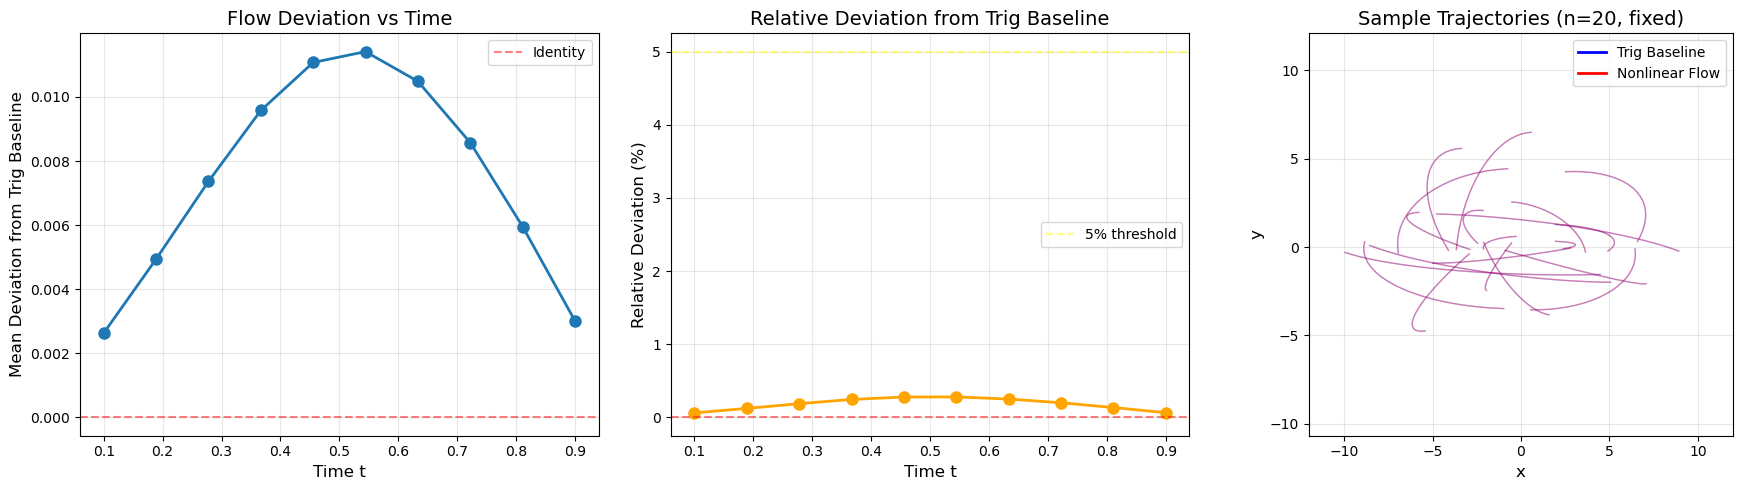

In [33]:
# Global storage for fixed trajectory endpoints for visualization
FIXED_VIZ_TRAJECTORY_POINTS = None

def get_fixed_viz_trajectory_points(base_fn, target_fn, n_trajectories=20, seed=42):
    """
    Generate or retrieve fixed start and end points for trajectory visualization.
    These points remain constant across all epochs for consistent visualization.
    """
    global FIXED_VIZ_TRAJECTORY_POINTS
    
    if FIXED_VIZ_TRAJECTORY_POINTS is None:
        # Set seed for reproducibility
        torch.manual_seed(seed)
        np.random.seed(seed)
        
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # Generate diverse starting and ending points
        x0_points = base_fn(n_trajectories).to(device)
        x1_points = target_fn(n_trajectories).to(device)
        
        FIXED_VIZ_TRAJECTORY_POINTS = {
            'x0': x0_points.detach().clone(),
            'x1': x1_points.detach().clone(),
            'seed': seed,
            'n_trajectories': n_trajectories
        }
        
        # Reset random state
        torch.manual_seed(torch.initial_seed() if torch.initial_seed() is not None else int(time.time()))
        
    return FIXED_VIZ_TRAJECTORY_POINTS['x0'], FIXED_VIZ_TRAJECTORY_POINTS['x1']


def check_flow_deviation_correct_baseline(interpolant, base, target, n_samples=5000, n_time_points=10, 
                                         n_viz_trajectories=20, trajectory_seed=42,
                                         save_path=None, epoch=None):
    """
    Measure deviation from the ACTUAL baseline: one-sided-trig interpolation.
    Uses fixed trajectory endpoints for consistent visualization across epochs.
    
    Parameters:
    -----------
    save_path : str, optional
        Directory to save the plots
    epoch : int, optional
        Epoch number for file naming
    """
    interpolant.flow_model.eval()
    
    with torch.no_grad():
        x0s = base(n_samples).to(device)
        x1s = target(n_samples).to(device)
        
        time_points = torch.linspace(0.1, 0.9, n_time_points, device=device)
        
        results = {
            'time': [],
            'mean_deviation': [],
            'max_deviation': [],
            'relative_deviation': []
        }
        
        for t_val in time_points:
            t = t_val.unsqueeze(0)  # [1]
            
            # ONE-SIDED-TRIG baseline (the ACTUAL baseline)
            alpha = torch.cos(np.pi * t / 2)
            beta = torch.sin(np.pi * t / 2)
            x_baseline = alpha * x0s + beta * x1s
            
            # Nonlinear flow interpolation
            x_flow = interpolant.calc_xt(t, x0s, x1s)
            if isinstance(x_flow, tuple):
                x_flow = x_flow[0]
            
            # Measure deviation
            deviation = torch.norm(x_flow - x_baseline, dim=-1)
            distance_traveled = torch.norm(x1s - x0s, dim=-1)
            
            mean_dev = deviation.mean().item()
            max_dev = deviation.max().item()
            relative_dev = (deviation / (distance_traveled + 1e-6)).mean().item() * 100
            
            results['time'].append(t_val.item())
            results['mean_deviation'].append(mean_dev)
            results['max_deviation'].append(max_dev)
            results['relative_deviation'].append(relative_dev)
    
    interpolant.flow_model.train()
    
    # Determine appropriate axis limits based on data
    # Get sample from base and target to determine scale
    with torch.no_grad():
        sample_x0 = base(1000).to(device)
        sample_x1 = target(1000).to(device)
        
        # Calculate data ranges
        x_min = min(sample_x0[:, 0].min().item(), sample_x1[:, 0].min().item())
        x_max = max(sample_x0[:, 0].max().item(), sample_x1[:, 0].max().item())
        y_min = min(sample_x0[:, 1].min().item(), sample_x1[:, 1].min().item())
        y_max = max(sample_x0[:, 1].max().item(), sample_x1[:, 1].max().item())
        
        # Add some padding
        x_range = x_max - x_min
        y_range = y_max - y_min
        x_lim = (x_min - 0.1 * x_range, x_max + 0.1 * x_range)
        y_lim = (y_min - 0.1 * y_range, y_max + 0.1 * y_range)
    
    # Visualization
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    axes[0].plot(results['time'], results['mean_deviation'], 'o-', linewidth=2, markersize=8)
    axes[0].set_xlabel('Time t', fontsize=12)
    axes[0].set_ylabel('Mean Deviation from Trig Baseline', fontsize=12)
    axes[0].set_title('Flow Deviation vs Time', fontsize=14)
    axes[0].grid(True, alpha=0.3)
    axes[0].axhline(y=0, color='red', linestyle='--', alpha=0.5, label='Identity')
    axes[0].legend()
    
    axes[1].plot(results['time'], results['relative_deviation'], 'o-', 
                 linewidth=2, markersize=8, color='orange')
    axes[1].set_xlabel('Time t', fontsize=12)
    axes[1].set_ylabel('Relative Deviation (%)', fontsize=12)
    axes[1].set_title('Relative Deviation from Trig Baseline', fontsize=14)
    axes[1].grid(True, alpha=0.3)
    axes[1].axhline(y=0, color='red', linestyle='--', alpha=0.5)
    axes[1].axhline(y=5, color='yellow', linestyle='--', alpha=0.5, label='5% threshold')
    axes[1].legend()
    
    # Plot 3: Compare trajectories with FIXED endpoints
    # Get fixed trajectory endpoints
    x0_viz, x1_viz = get_fixed_viz_trajectory_points(base, target, n_viz_trajectories, trajectory_seed)
    
    with torch.no_grad():
        t_dense = torch.linspace(0, 1, 20, device=device)
        
        for i in range(n_viz_trajectories):
            baseline_traj = []
            flow_traj = []
            
            for t in t_dense:
                t_tensor = t.unsqueeze(0)
                
                # Trig baseline
                alpha = torch.cos(np.pi * t / 2)
                beta = torch.sin(np.pi * t / 2)
                x_base = alpha * x0_viz[i:i+1] + beta * x1_viz[i:i+1]
                baseline_traj.append(grab(x_base[0]))
                
                # Flow
                x_fl = interpolant.calc_xt(t_tensor, x0_viz[i:i+1], x1_viz[i:i+1])
                if isinstance(x_fl, tuple):
                    x_fl = x_fl[0]
                flow_traj.append(grab(x_fl[0]))
            
            baseline_traj = np.array(baseline_traj)
            flow_traj = np.array(flow_traj)
            
            axes[2].plot(baseline_traj[:, 0], baseline_traj[:, 1], 
                        'b-', alpha=0.3, linewidth=1)
            axes[2].plot(flow_traj[:, 0], flow_traj[:, 1], 
                        'r-', alpha=0.3, linewidth=1)
    
    axes[2].plot([], [], 'b-', label='Trig Baseline', linewidth=2)
    axes[2].plot([], [], 'r-', label='Nonlinear Flow', linewidth=2)
    axes[2].set_xlabel('x', fontsize=12)
    axes[2].set_ylabel('y', fontsize=12)
    axes[2].set_title(f'Sample Trajectories (n={n_viz_trajectories}, fixed)', fontsize=14)
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    axes[2].set_xlim(x_lim)
    axes[2].set_ylim(y_lim)
    
    # Make aspect ratio match the data
    axes[2].set_aspect('equal', adjustable='box')
    
    # Add overall title with epoch information
    if epoch is not None:
        fig.suptitle(f'Flow Deviation Analysis - Epoch {epoch}', fontsize=16, y=1.02)
    
    plt.tight_layout()
    
    # Save the figure if save_path is provided
    if save_path is not None:
        import os
        os.makedirs(save_path, exist_ok=True)
        
        if epoch is not None:
            filename = f"{save_path}/flow_deviation_epoch_{epoch:04d}.png"
        else:
            filename = f"{save_path}/flow_deviation.png"
        plt.savefig(filename, dpi=100, bbox_inches='tight')
        print(f"Saved flow deviation plot to {filename}")
    
    plt.show()
    
    return results


# Run corrected diagnostic
results_correct = check_flow_deviation_correct_baseline(warmup_interpolant, base, target_rect, 
                                                       n_samples=5000, n_viz_trajectories=20)

Experiment will be saved to: results_rect/exp_20251003_024702_w10.0h0.10_bvar3.0_interp_base_2L32h2t_2e-03_2e-04_1000i_100o_500ep_1000bs_cosineannealing
Base distribution variance: 3.0
Interpolant mode: base
Time embedding dim: 2
Configuration saved to: results_rect/exp_20251003_024702_w10.0h0.10_bvar3.0_interp_base_2L32h2t_2e-03_2e-04_1000i_100o_500ep_1000bs_cosineannealing/experiment_config.json

Starting training for 500 epochs...
Base variance: 3.0, Target: rect, Interpolant: base
Epoch 1/500 [nonlinear]: v_loss=-8.8806, flow_loss=-10.0565, v_grad=11.9412, flow_grad=2.1132, E[|v|²]=19.4659
Epoch 2/500 [nonlinear]: v_loss=-9.8566, flow_loss=-9.4657, v_grad=5.1414, flow_grad=4.2035, E[|v|²]=21.1582
Epoch 3/500 [nonlinear]: v_loss=-8.8999, flow_loss=-7.7873, v_grad=8.3463, flow_grad=3.6709, E[|v|²]=18.5275
Epoch 4/500 [nonlinear]: v_loss=-8.6970, flow_loss=-7.9922, v_grad=5.8492, flow_grad=3.3712, E[|v|²]=17.5333
Epoch 5/500 [nonlinear]: v_loss=-8.8998, flow_loss=-9.2765, v_grad=4.789

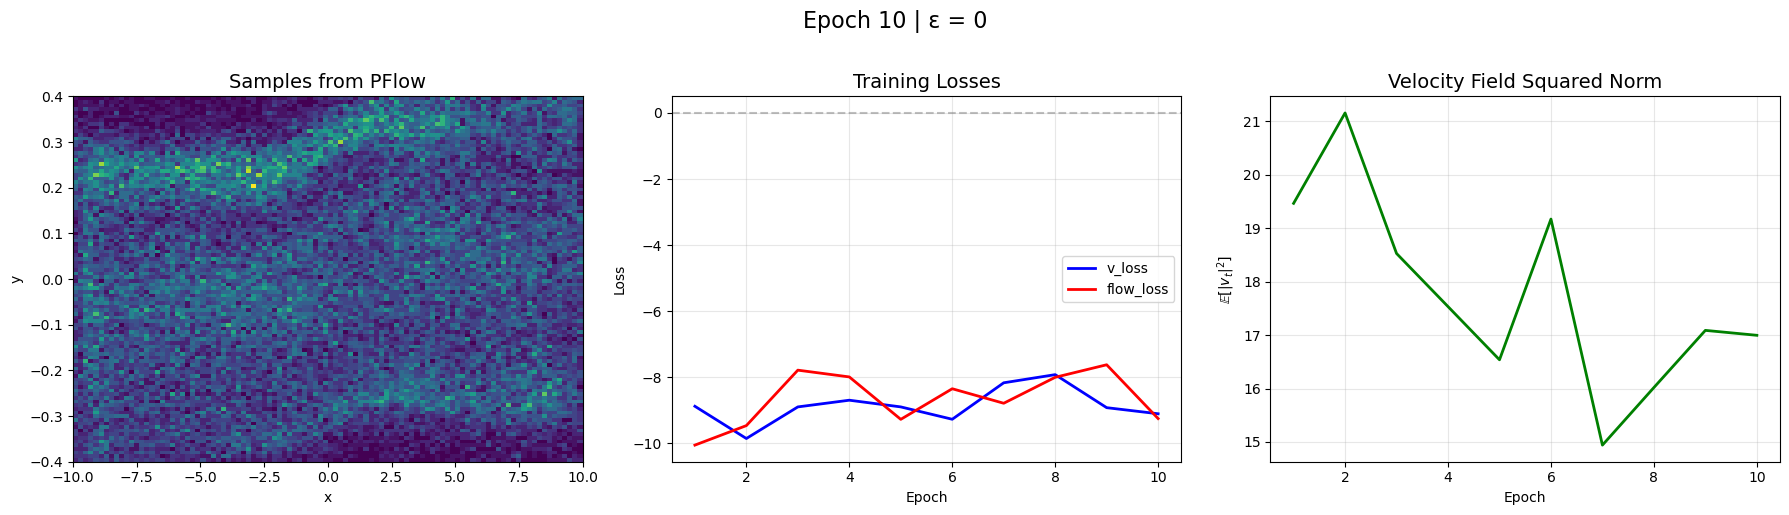

Saved flow deviation plot to results_rect/exp_20251003_024702_w10.0h0.10_bvar3.0_interp_base_2L32h2t_2e-03_2e-04_1000i_100o_500ep_1000bs_cosineannealing/flow_deviation_epoch_0010.png


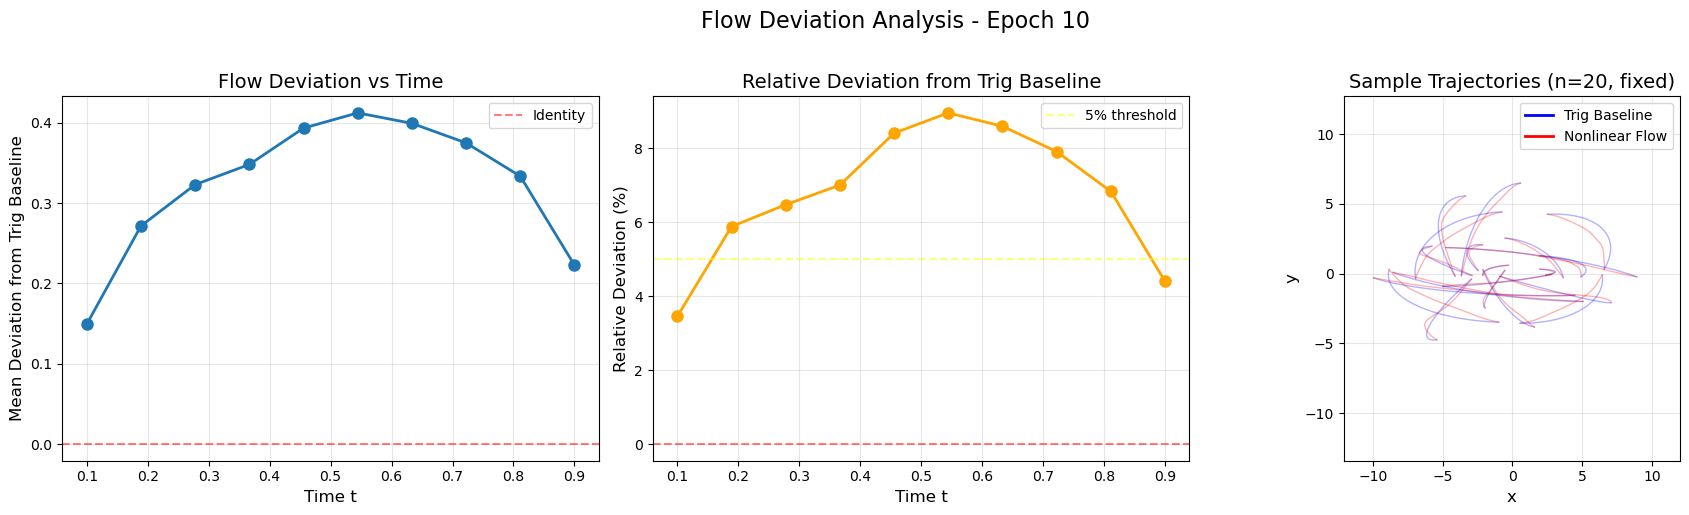

Epoch 11/500 [nonlinear]: v_loss=-8.1256, flow_loss=-9.0127, v_grad=6.3502, flow_grad=3.5380, E[|v|²]=15.6643
Epoch 12/500 [nonlinear]: v_loss=-8.4699, flow_loss=-7.8823, v_grad=5.5074, flow_grad=0.8633, E[|v|²]=17.0345
Epoch 13/500 [nonlinear]: v_loss=-8.0924, flow_loss=-8.8777, v_grad=4.7717, flow_grad=2.6749, E[|v|²]=16.9800
Epoch 14/500 [nonlinear]: v_loss=-8.7407, flow_loss=-8.8450, v_grad=2.4839, flow_grad=1.8697, E[|v|²]=17.0395
Epoch 15/500 [nonlinear]: v_loss=-8.0104, flow_loss=-8.9368, v_grad=4.3627, flow_grad=1.7411, E[|v|²]=16.5962
Epoch 16/500 [nonlinear]: v_loss=-8.5534, flow_loss=-8.9236, v_grad=2.9926, flow_grad=1.5588, E[|v|²]=17.2559
Epoch 17/500 [nonlinear]: v_loss=-7.3574, flow_loss=-7.9349, v_grad=5.4950, flow_grad=1.4550, E[|v|²]=16.4659
Epoch 18/500 [nonlinear]: v_loss=-7.8490, flow_loss=-8.8135, v_grad=3.4149, flow_grad=1.9987, E[|v|²]=16.0660
Epoch 19/500 [nonlinear]: v_loss=-8.9721, flow_loss=-9.0278, v_grad=3.5554, flow_grad=1.4444, E[|v|²]=17.5068
Epoch 20/5

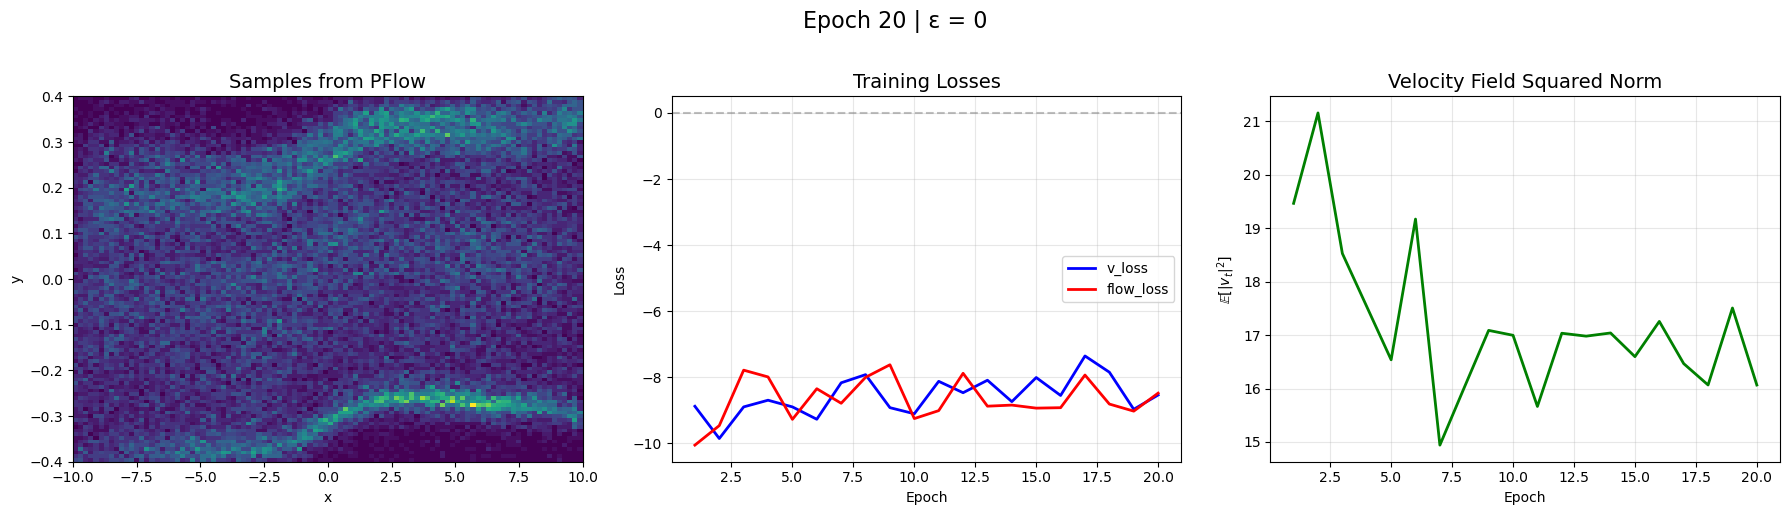

Saved flow deviation plot to results_rect/exp_20251003_024702_w10.0h0.10_bvar3.0_interp_base_2L32h2t_2e-03_2e-04_1000i_100o_500ep_1000bs_cosineannealing/flow_deviation_epoch_0020.png


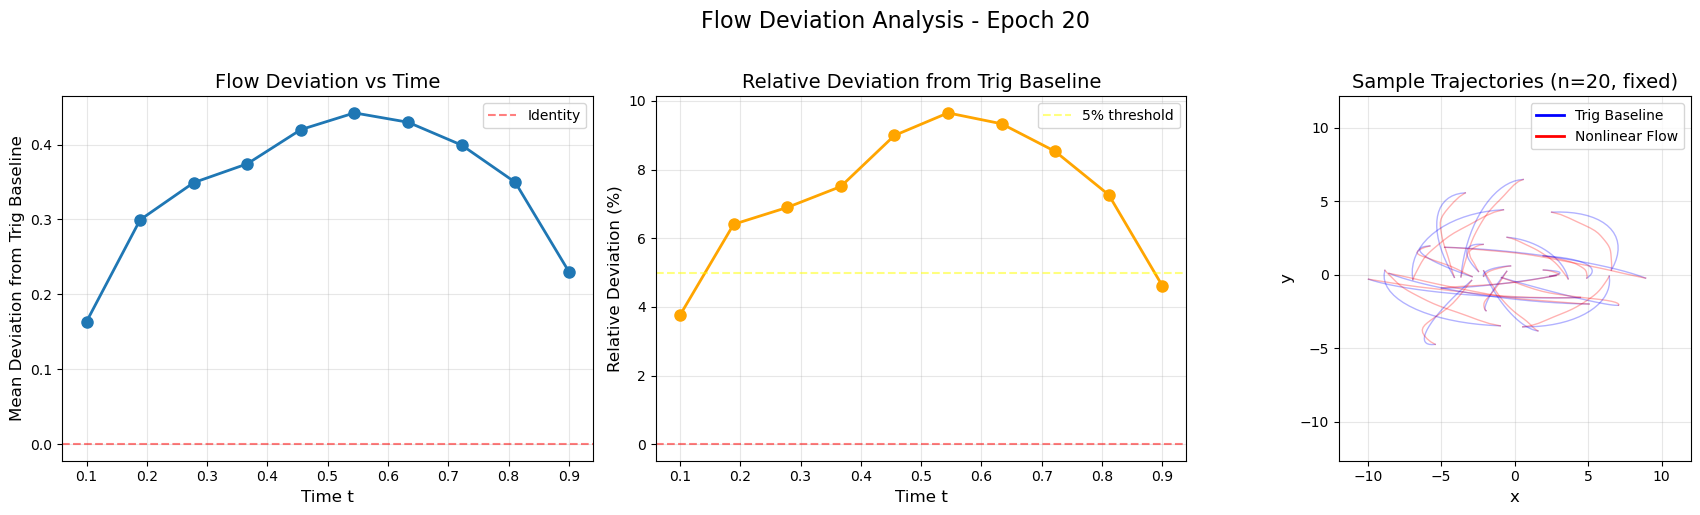

Epoch 21/500 [nonlinear]: v_loss=-8.1791, flow_loss=-9.0379, v_grad=4.8315, flow_grad=1.6367, E[|v|²]=17.0707
Epoch 22/500 [nonlinear]: v_loss=-8.7920, flow_loss=-7.4193, v_grad=4.8685, flow_grad=1.1921, E[|v|²]=17.0239
Epoch 23/500 [nonlinear]: v_loss=-8.7506, flow_loss=-8.1519, v_grad=3.5820, flow_grad=3.6415, E[|v|²]=16.3622
Epoch 24/500 [nonlinear]: v_loss=-8.3383, flow_loss=-7.3721, v_grad=3.6293, flow_grad=3.5593, E[|v|²]=17.9350


In [ ]:
# ============================================================================
# EXPERIMENT CONFIGURATION AND SAVING
# ============================================================================

import os
import json
from datetime import datetime

def create_experiment_path(target_type, target_kwargs, flow_config, base_lr_v, base_lr_flow, 
                          n_inner, n_outer, N_epoch, bs, base_variance, interpolant_mode):
    """Create organized experiment directory name with key parameters."""
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Format target parameters based on target type
    if target_type == "rect":
        target_str = f"w{target_kwargs.get('w', 1.0):.1f}h{target_kwargs.get('h', 0.1):.2f}"
    elif target_type == "rhombus":
        target_str = f"s{target_kwargs.get('s', 1.0):.1f}a{target_kwargs.get('angle_deg', 10):.0f}"
    elif target_type == "parallelogram":
        target_str = f"a{target_kwargs.get('len_a', 1):.1f}b{target_kwargs.get('len_b', 1):.1f}ang{target_kwargs.get('angle_deg', 60):.0f}"
    else:
        target_str = target_type
    
    # Format flow config including time embedding
    time_emb = flow_config.get('time_embed_dim', 128)
    flow_str = f"{flow_config.get('num_layers', 2)}L{flow_config.get('hidden', 256)}h{time_emb}t"
    
    # Format base variance (e.g., bvar1.0 or bvar0.5)
    base_var_str = f"bvar{base_variance:.1f}"
    
    # Format interpolant mode
    interp_str = f"interp_{interpolant_mode}"
    
    # Create path
    path = f"results_{target_type}/exp_{timestamp}_{target_str}_{base_var_str}_{interp_str}_{flow_str}_{base_lr_v:.0e}_{base_lr_flow:.0e}_{n_inner}i_{n_outer}o_{N_epoch}ep_{bs}bs_cosineannealing"
    
    return path

def make_json_serializable(obj):
    """Convert non-serializable objects to serializable format."""
    import torch
    import numpy as np
    
    if isinstance(obj, dict):
        return {k: make_json_serializable(v) for k, v in obj.items()}
    elif isinstance(obj, (list, tuple)):
        return [make_json_serializable(v) for v in obj]
    elif isinstance(obj, torch.device):
        return str(obj)
    elif isinstance(obj, torch.dtype):
        return str(obj)
    elif torch.is_tensor(obj):
        return obj.detach().cpu().tolist()
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, (np.floating, np.integer)):
        return obj.item()
    else:
        return obj

def save_experiment_config(save_path, target_type, target_kwargs, flow_config, 
                          base_lr_v, base_lr_flow, n_inner, n_outer, N_epoch, bs,
                          hidden_sizes, metrics_freq, plot_freq, n_save, n_step, base_variance,
                          interpolant_mode, warmup_steps=None):
    """Save all experiment configuration to a JSON file."""
    
    # Clean target_kwargs for JSON serialization
    clean_target_kwargs = make_json_serializable(target_kwargs)
    
    config = {
        "experiment": {
            "timestamp": datetime.now().isoformat(),
            "save_path": save_path,
            "target_type": target_type,
        },
        "interpolant": {
            "mode": interpolant_mode,
            "active_type": "nonlinear" if interpolant_mode == "base" else "linear" if interpolant_mode == "aux" else "warmup",
            "warmup_steps": warmup_steps if interpolant_mode == "warmup" else None,
            "base_type": "nonlinear_flow",
            "aux_type": "one-sided-trig"
        },
        "base_distribution": {
            "type": "SimpleNormal",
            "mean": 0.0,
            "variance": base_variance,
            "dimension": 2
        },
        "target_parameters": clean_target_kwargs,
        "flow_config": flow_config,
        "training": {
            "base_lr_v": base_lr_v,
            "base_lr_flow": base_lr_flow,
            "n_inner": n_inner,
            "n_outer": n_outer,
            "N_epoch": N_epoch,
            "batch_size": bs,
        },
        "network": {
            "v_hidden_sizes": hidden_sizes,
            "v_activation": inner_act,
        },
        "logging": {
            "metrics_freq": metrics_freq,
            "plot_freq": plot_freq,
            "n_save": n_save,
            "n_step": n_step,
        }
    }
    
    # Create directory if it doesn't exist
    os.makedirs(save_path, exist_ok=True)
    
    # Save config
    config_path = os.path.join(save_path, "experiment_config.json")
    with open(config_path, "w") as f:
        json.dump(config, f, indent=2)
    
    print(f"Configuration saved to: {config_path}")
    return config

def save_training_results(save_path, data_dict):
    """Save training metrics to JSON file."""
    data_path = os.path.join(save_path, "training_metrics.json")
    
    def _json_default(o):
        import numpy as np, torch
        if isinstance(o, (np.floating, np.integer)):
            return o.item()
        if isinstance(o, np.ndarray):
            return o.tolist()
        if torch.is_tensor(o):
            return o.detach().cpu().tolist()
        raise TypeError(f"Object of type {type(o).__name__} is not JSON serializable")
    
    with open(data_path, "w") as f:
        json.dump(data_dict, f, indent=2, default=_json_default)
    
    print(f"Training metrics saved to: {data_path}")

# ============================================================================
# CONFIGURE YOUR EXPERIMENT HERE
# ============================================================================

# BASE DISTRIBUTION CONFIGURATION
# base_variance = 3.0  # Already defined in the base distribution cell - you can override here if needed

# Choose target type and parameters
target_type = "rect"  # Options: "rect", "rhombus", "parallelogram"
target_kwargs = {
    'w': 10.0,
    'h': 0.1,
    'layers_x': 2,
    'layers_y': 4,
    'scale': 1.0,
    'device': device,
    'dtype': torch.float32
}

# Select target function based on type
if target_type == "rect":
    target_fn = target_rect
elif target_type == "rhombus":
    target_fn = target_rhombus
elif target_type == "parallelogram":
    target_fn = target_parallelogram
else:
    target_fn = target  # Default checker

# Create organized save path (now includes time_embed_dim)
save_path = create_experiment_path(
    target_type=target_type,
    target_kwargs=target_kwargs,
    flow_config=flow_config,
    base_lr_v=base_lr_v,
    base_lr_flow=base_lr_flow,
    n_inner=n_inner,
    n_outer=n_outer,
    N_epoch=N_epoch,
    bs=bs,
    base_variance=base_variance,
    interpolant_mode=INTERPOLANT_MODE
)

print(f"Experiment will be saved to: {save_path}")
print(f"Base distribution variance: {base_variance}")
print(f"Interpolant mode: {INTERPOLANT_MODE}")
print(f"Time embedding dim: {flow_config.get('time_embed_dim', 128)}")

# Save experiment configuration (now includes interpolant settings)
experiment_config = save_experiment_config(
    save_path=save_path,
    target_type=target_type,
    target_kwargs=target_kwargs,
    flow_config=flow_config,
    base_lr_v=base_lr_v,
    base_lr_flow=base_lr_flow,
    n_inner=n_inner,
    n_outer=n_outer,
    N_epoch=N_epoch,
    bs=bs,
    hidden_sizes=hidden_sizes,
    metrics_freq=metrics_freq,
    plot_freq=plot_freq,
    n_save=n_save,
    n_step=n_step,
    base_variance=base_variance,
    interpolant_mode=INTERPOLANT_MODE,
    warmup_steps=N_warmup if INTERPOLANT_MODE == 'warmup' else None
)

# ============================================================================
# TRAINING LOOP
# ============================================================================

print(f"\nStarting training for {N_epoch} epochs...")
print(f"Base variance: {base_variance}, Target: {target_type}, Interpolant: {INTERPOLANT_MODE}")
print("="*70)

for epoch in range(N_epoch):
    # Training step with configured target
    loss_v, loss_flow, v_grad, flow_grad = train_step(
        bs=bs,
        interpolant=warmup_interpolant,
        v=v,
        opt_v=opt_v,
        opt_flow=opt_flow,
        sched_v=sched_v,
        sched_flow=sched_flow,
        n_inner=n_inner,
        n_outer=n_outer,
        reuse_batch=False,
        clip_v=float('inf'),
        clip_flow=float('inf'),
        train_v_only=False,
        warmup_step=epoch,
        base_fn=base,
        target_fn=target_fn,
        target_kwargs=target_kwargs,
        device=device
    )

    # Log metrics
    data_dict['v_losses'].append(grab(loss_v).mean())
    data_dict['flow_losses'].append(grab(loss_flow).mean())
    data_dict['v_grads'].append(grab(v_grad).mean())
    data_dict['flow_grads'].append(grab(flow_grad).mean())

    # Estimate E[|v|^2]
    v_sq_norm = estimate_v_squared_norm_grid(
        v, warmup_interpolant, base, target_fn,
        n_samples=50000, n_time_points=100, device=device
    )
    data_dict['v_squared_norm'].append(v_sq_norm)

    # Print progress
    active_interp = warmup_interpolant.get_active_interpolant_name()
    print(f"Epoch {epoch+1}/{N_epoch} [{active_interp}]: v_loss={loss_v.item():.4f}, "
          f"flow_loss={loss_flow.item():.4f}, v_grad={v_grad.item():.4f}, "
          f"flow_grad={flow_grad.item():.4f}, E[|v|²]={v_sq_norm:.4f}")

    # Save plots periodically (every 10 epochs) and at the end
    if (epoch + 1) % 10 == 0 or epoch == N_epoch - 1:
        # Create width/height for plotting based on target type
        if target_type == "rect":
            plot_width = target_kwargs.get('w', 1.0) * target_kwargs.get('layers_x', 2) * target_kwargs.get('scale', 1.0) / 2
            plot_height = target_kwargs.get('h', 0.1) * target_kwargs.get('layers_y', 4) * target_kwargs.get('scale', 1.0)
        else:
            plot_width = 1.0
            plot_height = 0.1
            
        make_plots(
            v, v, warmup_interpolant, n_save, n_step, plot_bs, counter, metrics_freq,
            torch.tensor(0), data_dict, 
            save_path=save_path, 
            epoch=epoch+1, 
            width=plot_width, 
            height=plot_height
        )
        
        # Check flow deviation and save the plots
        results_correct = check_flow_deviation_correct_baseline(
            warmup_interpolant, base, target_fn, n_samples=5000,
            save_path=save_path,  # Pass save_path
            epoch=epoch+1  # Pass epoch number
        )

# ============================================================================
# SAVE FINAL RESULTS
# ============================================================================

print("\n" + "="*70)
print("Training complete! Saving results...")

# Save training metrics
save_training_results(save_path, data_dict)

# Save model checkpoints
checkpoint_path = os.path.join(save_path, "model_checkpoint.pt")
torch.save({
    'epoch': N_epoch,
    'v_state_dict': v.state_dict(),
    'flow_model_state_dict': warmup_interpolant.flow_model.state_dict(),
    'opt_v_state_dict': opt_v.state_dict(),
    'opt_flow_state_dict': opt_flow.state_dict(),
    'data_dict': data_dict,
    'base_variance': base_variance,
    'interpolant_mode': INTERPOLANT_MODE,
    'warmup_steps': N_warmup if INTERPOLANT_MODE == 'warmup' else None
}, checkpoint_path)
print(f"Model checkpoint saved to: {checkpoint_path}")

print(f"\nAll results saved to: {save_path}")
print(f"Experiment used: base_variance={base_variance}, interpolant={INTERPOLANT_MODE}")
print("="*70)

In [ ]:
make_plots(
            v, v, warmup_interpolant, n_save, n_step, 50000, counter, metrics_freq,
            torch.tensor(0), data_dict, 
            #save_path=save_path, 
            epoch=epoch+1, 
            width=plot_width, 
            height=plot_height
        )

NameError: name 'make_plots' is not defined

In [ ]:
# Let's see what's defined in the current notebook
import torch
import matplotlib.pyplot as plt

# Check if target_rect is defined and what shape it has
if 'target_rect' in globals():
    print(f"target_rect shape: {target_rect.shape}")
    print(f"target_rect dtype: {target_rect.dtype}")
    print(f"target_rect min/max: {target_rect.min():.3f}, {target_rect.max():.3f}")
else:
    print("target_rect not yet defined")

# Check data dimension
if 'data_dim' in globals():
    print(f"data_dim: {data_dim}")
else:
    print("data_dim not defined")

target_rect not yet defined
data_dim not defined
